In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from rdp import rdp
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
from itertools import combinations_with_replacement
import math

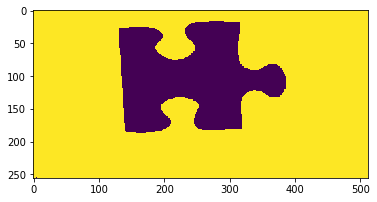

In [2]:
img = cv2.imread("RP1_cropped.jpg", cv2.IMREAD_COLOR)
img =cv2.resize(img  , (512, 256))
#plt.imshow(img)
gray = cv2.cvtColor(img , cv2.COLOR_RGB2GRAY)
blurred_frame = cv2.GaussianBlur(gray, (5, 5), 0)
ret,thresh = cv2.threshold(blurred_frame,127,255,cv2.THRESH_BINARY)
plt.imshow(thresh)
#hsv = cv2.cvtColor(blurred_frame, cv2.COLOR_BGR2HSV)


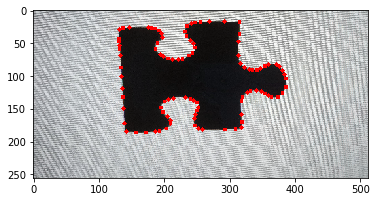

[[315, 18], [318, 179], [132, 29], [142, 185], [195, 148], [232, 32], [247, 57], [250, 140], [243, 65], [235, 24], [252, 180], [203, 180], [247, 175], [245, 137], [327, 125], [323, 87], [354, 85], [372, 83], [317, 81], [199, 70], [187, 59], [234, 39], [242, 20], [172, 186], [157, 186], [187, 185], [193, 184], [293, 182], [259, 182], [309, 181], [210, 173], [139, 172], [319, 170], [210, 168], [246, 165], [318, 159], [248, 159], [250, 153], [138, 150], [252, 148], [318, 138], [207, 136], [240, 135], [214, 134], [233, 133], [374, 132], [364, 132], [137, 132], [349, 124], [332, 123], [341, 122], [136, 119], [386, 117], [386, 104], [135, 101], [384, 98], [342, 91], [335, 91], [330, 90], [347, 89], [134, 87], [359, 83], [222, 75], [213, 75], [228, 74], [206, 73], [314, 69], [133, 69], [314, 48], [197, 41], [315, 36], [186, 28], [181, 27], [137, 27], [176, 26], [147, 26], [247, 19], [255, 18], [292, 17], [269, 17], [132, 59], [132, 54], [131, 48], [131, 43], [190, 50], [205, 162], [198, 155],

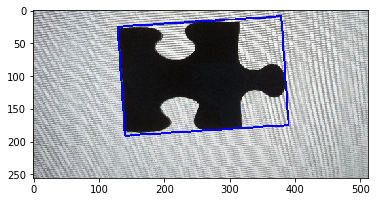

In [3]:
corners = cv2.goodFeaturesToTrack(thresh,100,0.01,5)
corners = np.int0(corners)
#print(corners)
corners_list=[]
img_with_corners = img.copy()
#print(corners.ravel())
for i in corners:
    x,y = i.ravel()
    corners_list.append([x,y])
    img_with_corners = cv2.circle(img_with_corners,(x,y),3,255,-1)
plt.imshow(img_with_corners),plt.show()
cv2.namedWindow('corners', cv2.WINDOW_NORMAL)
cv2.imshow('corners', img_with_corners)
plt.imshow(img_with_corners)
key = cv2.waitKey(10000)
cv2.destroyAllWindows()
print(corners_list)
print(len(corners_list))
rect = cv2.minAreaRect(corners)
box = cv2.boxPoints(rect)
box = np.int0(box)
img_with_box = img.copy()
img_with_box = cv2.drawContours(img_with_box,[box],0,(0,0,255),2)
print(box)
cv2.namedWindow("img_with_box" , cv2.WINDOW_NORMAL)
cv2.imshow("img_with_box", img_with_box)
key = cv2.waitKey(10000)
cv2.destroyAllWindows()
plt.imshow(img_with_box)

259
100
(259, 100)


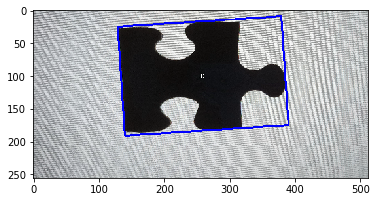

In [4]:
#Finding the center point of the rectangle
center_x =int((box[1][0] + box[3][0])/2)
center_y =int((box[1][1] + box[3][1])/2)
print(center_x)
print(center_y)
img_center = cv2.circle(img_with_box, (center_x, center_y) , 3, (255,255,255),1)
plt.imshow(img_center)
tile_center= (center_x , center_y)
tile_center = tuple(np.round(tile_center).astype(np.int))
print(tile_center)

130304.0
27920.5


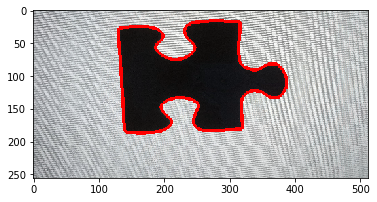

In [5]:
_, contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
img_with_contours= img.copy()
for contour in contours:
    area = cv2.contourArea(contour)
    print(area)
    if   (area  < 60000):
        #contour_final.append(contour)
        cv2.drawContours(img_with_contours, contour, -1, (255, 0, 0), 3)
#print(contours)
#cv2.circle(img_with_contours, (tile_center1[1] , tile_center1[0]), 5 , (255,0,0), 3)
plt.imshow(img_with_contours)

In [6]:
def get_vector(p1, p2):
    if type(p1).__module__ != np.__name__:
        p1 = np.array(p1)
    if type(p2).__module__ != np.__name__:
        p2 = np.array(p2)
    return p2 - p1

In [7]:
def get_angle(p1,p2,p3):
    """calculate angle between p2_p3 and p2_p3"""
    p2p1 = get_vector(p2,p1)
    p2p3 = get_vector(p2,p3)
    cosine_angle = np.dot(p2p1, p2p3) / (np.linalg.norm(p2p1) * np.linalg.norm(p2p3))
    angle = np.arccos(cosine_angle)
    np.seterr(divide='ignore', invalid='ignore')
    #print(np.degrees(angle))
    return np.degrees(angle)

In [8]:
def sort_points(xylist):
    x, y = zip(*xylist)
    #print(x)
    #print(y)
    l = len(x)
    (cx , cy) = tile_center
    xy_sorted = sorted(xylist, key = lambda x: math.atan2((x[1]-cy),(x[0]-cx)))
    return xy_sorted
        

In [9]:
#new =[]
angle_margin =30
corners=corners_list
corner_left_top_candidates=[]
corner_left_bottom_candidates=[]
angle_candidates_left_top =[]
angle_candidates_left_bottom =[]
#print(corners)
margin =30
def corners_new_left():
    for c1 in corners:
        #print(c1) 
        if c1[0] <= tile_center[0] and c1[1] <= tile_center[1]:
            corner_left_top_candidates.append(c1)
    #print(corner_left_top_candidates)
    corner_left_top_candidates_sorted = sort_points(corner_left_top_candidates)
    #print(corner_left_top_candidates_sorted)
    for i in range(len(corner_left_top_candidates_sorted)-2):
        a = get_angle(corner_left_top_candidates_sorted[i],corner_left_top_candidates_sorted[i+1],corner_left_top_candidates_sorted[i+2])
        #del corner_left_top_candidates_sorted[0]
        if 90 - margin < a < 90 + margin:
            angle_candidates_left_top.append(corner_left_top_candidates_sorted[i+1])
    
    
    for c1 in corners:
        #print(c1) 
        if c1[0] <= tile_center[0] and c1[1] >= tile_center[1]:
            corner_left_bottom_candidates.append(c1)
   # print(corner_left_bottom_candidates)
    corner_left_bottom_candidates_sorted = sort_points(corner_left_bottom_candidates)
    #print(corner_left_bottom_candidates_sorted)
    for i in range(len(corner_left_bottom_candidates_sorted)-2):
        a = get_angle(corner_left_bottom_candidates_sorted[i],corner_left_bottom_candidates_sorted[i+1],corner_left_bottom_candidates_sorted[i+2])
        #del corner_left_top_candidates_sorted[0]
        if 90 - margin < a < 90 + margin:
            angle_candidates_left_bottom.append(corner_left_bottom_candidates_sorted[i+1])
            
    #print(angle_candidates)
    #corner_left_top_candidates_combination = list(combinations_with_replacement(corner_left_top_candidates, 2)) 
    #print(corner_left_top_candidates_combination)
    
    
    return angle_candidates_left_top ,angle_candidates_left_bottom
    

In [10]:
angle_margin = 30
corners=corners_list
corner_right_top_candidates=[]
corner_right_bottom_candidates=[]
angle_candidates_right_top =[]
angle_candidates_right_bottom =[]
def corners_new_right():
    for c1 in corners:
        #print(c1) 
        if c1[0] >= tile_center[0] and c1[1] <= tile_center[1]:
            corner_right_top_candidates.append(c1)
    #print(corner_right_top_candidates)
    #corner_right_top_candidates_sorted = sorted(corner_right_top_candidates, key=lambda x: x[0])
    corner_right_top_candidates_sorted = sort_points(corner_right_top_candidates)
    #print(corner_right_top_candidates_sorted)
    for i in range(len(corner_right_top_candidates_sorted)-2):
        a = get_angle(corner_right_top_candidates_sorted[i],corner_right_top_candidates_sorted[i+1],corner_right_top_candidates_sorted[i+2])
        #del corner_left_top_candidates_sorted[0]
        if 90 - margin < a < 90 + margin :
            angle_candidates_right_top.append(corner_right_top_candidates_sorted[i+1])
    
    
    for c1 in corners:
        #print(c1) 
        if c1[0] >= tile_center[0] and c1[1] >= tile_center[1]:
            corner_right_bottom_candidates.append(c1)
    #print(corner_right_bottom_candidates)
    corner_right_bottom_candidates_sorted = sort_points(corner_right_bottom_candidates)
    #print(corner_right_bottom_candidates_sorted)
    for i in range(len(corner_right_bottom_candidates_sorted)-2):
        a = get_angle(corner_right_bottom_candidates_sorted[i],corner_right_bottom_candidates_sorted[i+1],corner_right_bottom_candidates_sorted[i+2])
        #del corner_left_top_candidates_sorted[0]
        if 90 - margin < a < 90 + margin:
            angle_candidates_right_bottom.append(corner_right_bottom_candidates_sorted[i+1])
            
    #print(angle_candidates)
    #corner_left_top_candidates_combination = list(combinations_with_replacement(corner_left_top_candidates, 2)) 
    #print(corner_left_top_candidates_combination)
    
    
    return angle_candidates_right_top ,angle_candidates_right_bottom

[[131, 43], [238, 69], [243, 65], [242, 20]]
[[252, 180], [250, 140], [240, 135], [139, 172]]


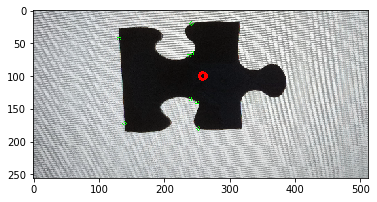

In [11]:
angle_candidates_left_top ,angle_candidates_left_bottom = corners_new_left()
print(angle_candidates_left_top)
print(angle_candidates_left_bottom)
for i in angle_candidates_left_top:
    img_candidates_left = cv2.circle(img, tuple(i), 3 , (0,255,0), 1)
for i in angle_candidates_left_bottom:
    img_candidates_left = cv2.circle(img, tuple(i), 3 , (0,255,0), 1)
cv2.circle(img_candidates_left, (tile_center[0] , tile_center[1]), 5 , (255,0,0), 3)   
plt.imshow(img_candidates_left)

[[315, 18], [381, 92]]
[[381, 126], [318, 179]]


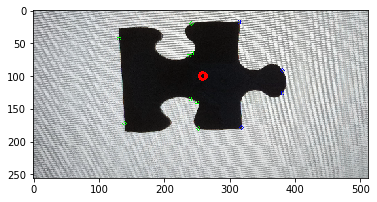

In [12]:
angle_candidates_right_top ,angle_candidates_right_bottom = corners_new_right()
print(angle_candidates_right_top)
print(angle_candidates_right_bottom)
for i in angle_candidates_right_top:
    img_candidates_right = cv2.circle(img, tuple(i), 3 , (0,0,255), 1)
for i in angle_candidates_right_bottom:
    img_candidates_right = cv2.circle(img, tuple(i), 3 , (0,0,255), 1)
#cv2.circle(img_candidates_right, (tile_center[0] , tile_center[1]), 5 , (255,0,0), 3)   
plt.imshow(img_candidates_right)

In [13]:
tile_center1 = ndimage.center_of_mass(thresh)
print(tile_center1)
tile_center1 = tuple(np.round(tile_center1).astype(np.int))
print(tile_center1)

(134.08043847460243, 259.61347846225107)
(134, 260)


130304.0
27920.5


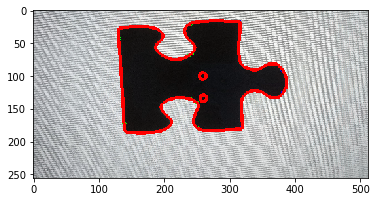

In [14]:
_, contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
img_with_contours= img.copy()
for contour in contours:
    area = cv2.contourArea(contour)
    print(area)
    if   (area  < 60000):
        #contour_final.append(contour)
        cv2.drawContours(img_with_contours, contour, -1, (255, 0, 0), 3)
#print(contours)
cv2.circle(img_with_contours, (tile_center1[1] , tile_center1[0]), 5 , (255,0,0), 3)
plt.imshow(img_with_contours)

In [15]:
def left_top_corner(angle_candidates_left_top):
    h =[]
    w=[]
    left_top_corner_point=[]
    for i in range(len(angle_candidates_left_top)):
        h.append(angle_candidates_left_top[i][0])
    print(h)
    d1 = h.index(min(h))
    print(min(h))
    for i in range(0, len(angle_candidates_left_top)):
        w.append(angle_candidates_left_top[i][1])
    d2 = w.index(min(w)) 
    left_top_corner_point.append(angle_candidates_left_top[d1])
    print(left_top_corner_point)
    print(angle_candidates_left_top[d2][1])
    if left_top_corner_point[0][1] > 50:
        del angle_candidates_left_top[d1]
        left_top_corner(angle_candidates_left_top)
    print(left_top_corner_point)
    return left_top_corner_point

[131, 238, 243, 242]
131
[[131, 43]]
20
[[131, 43]]


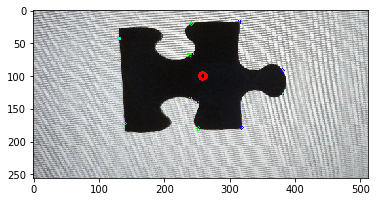

In [16]:
plot_corner_points = img.copy()
left_top_corner_point = left_top_corner(angle_candidates_left_top)
plot_corner_points =cv2.circle(plot_corner_points, (left_top_corner_point[0][0], left_top_corner_point[0][1]), 1, (0,255,255),2) 
plt.imshow(plot_corner_points)

In [19]:
def left_bottom_corner(angle_candidates_left_bottom):
    h =[]
    w=[]
    left_bottom_corner_point=[]
    print(angle_candidates_left_bottom)
    for i in range(0, len(angle_candidates_left_bottom)):
        h.append(angle_candidates_left_bottom[i][1])
    d1 = h.index(max(h))
    print(h)
    #print(d1)
    left_bottom_corner_point.append(angle_candidates_left_bottom[d1])
    print(angle_candidates_left_bottom[d1])
    print(left_top_corner_point[0][0] - 20)
    print(left_top_corner_point[0][0] + 20)
    if (left_top_corner_point[0][0] - 20) <= left_bottom_corner_point[0][0] <= (left_top_corner_point[0][0] + 20):
        return left_bottom_corner_point
    else:
        del angle_candidates_left_bottom[d1]
        left_bottom_corner(angle_candidates_left_bottom)
    print(left_bottom_corner_point)
    
    #return left_bottom_corner_point

[[250, 140], [240, 135], [139, 172]]
[140, 135, 172]
[139, 172]
111
151


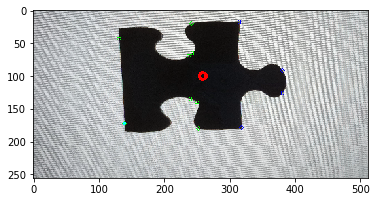

In [20]:
plot_corner_points = img.copy()
left_bottom_corner_point = left_bottom_corner(angle_candidates_left_bottom)
plot_corner_points =cv2.circle(plot_corner_points, (left_bottom_corner_point[0][0], left_bottom_corner_point[0][1]), 1, (0,255,255),2) 
plt.imshow(plot_corner_points)

In [23]:
def right_top_corner(angle_candidates_right_top):
    h =[]
    w=[]
    right_top_corner_point=[]
    print(angle_candidates_right_top)
    for i in range(0, len(angle_candidates_right_top)):
        h.append(angle_candidates_right_top[i][0])
    d1 = h.index(max(h))
    print(h)
    for i in range(0, len(angle_candidates_right_top)):
        w.append(angle_candidates_right_top[i][1])
    d2 = w.index(min(w))
    right_top_corner_point.append(angle_candidates_right_top[d1])
    print(angle_candidates_right_top[d1])
    print(right_top_corner_point[0][1])
    if right_top_corner_point[0][1] >= 75:
        del angle_candidates_right_top[d1]
        right_top_corner(angle_candidates_right_top)
    else:
        return right_top_corner_point
        
    print(right_top_corner_point)
    

[[315, 18]]
[315]
[315, 18]
18


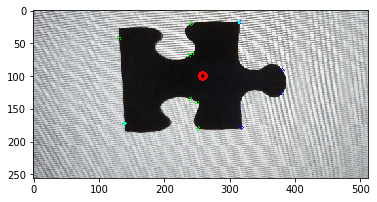

In [24]:
right_top_corner_point = right_top_corner(angle_candidates_right_top)
plot_corner_points =cv2.circle(plot_corner_points, (right_top_corner_point[0][0], right_top_corner_point[0][1]), 1, (0,255,255),2) 
plt.imshow(plot_corner_points)

In [25]:
def right_bottom_corner(angle_candidates_right_bottom):
    h =[]
    w=[]
    right_bottom_corner_point=[]
    print(angle_candidates_right_bottom)
    for i in range(0, len(angle_candidates_right_bottom)):
        print(i)
        h.append(angle_candidates_right_bottom[i][1])
        #print(h)
    print(h)
    d1 = h.index(max(h))
    
    #print(d1)
    right_bottom_corner_point.append(angle_candidates_right_bottom[d1])
    print(angle_candidates_right_bottom[d1])
    if (right_top_corner_point[0][0] - 20) <= right_bottom_corner_point[0][0] <= (right_top_corner_point[0][0] + 20):
        return right_bottom_corner_point
    else:
        del angle_candidates_right_bottom[d1]
        right_bottom_corner(angle_candidates_right_bottom)
    print(right_bottom_corner_point)
    
    #return left_bottom_corner_point

[[381, 126], [318, 179]]
0
1
[126, 179]
[318, 179]


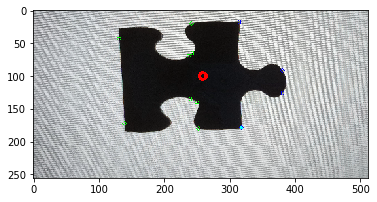

In [26]:
plot_corner_points = img.copy()
right_bottom_corner_point = right_bottom_corner(angle_candidates_right_bottom)
plot_corner_points =cv2.circle(plot_corner_points, (right_bottom_corner_point[0][0], right_bottom_corner_point[0][1]), 1, (0,255,255),2) 
plt.imshow(plot_corner_points)

In [27]:
#Sorting male female components
left_shape_male = []
left_shape_female = []
left_top_corner_point = left_top_corner(angle_candidates_left_top)
left_bottom_corner_point = left_bottom_corner(angle_candidates_left_bottom)
corners=corners_list
#print(corners)
for c in corners:
    if c[0] < tile_center[0] \
    and ((left_top_corner_point[0][1] +10) <= c[1] <= (left_bottom_corner_point[0][1] - 10)):
        if (left_top_corner_point[0][0] - 50) <c[0] < (left_top_corner_point[0][0]):
        #if (c[0] <= max(left_top_corner_point[0][0],left_bottom_corner_point[0][0])):
            left_shape_male.append(c)
        elif (left_top_corner_point[0][0] ) < c[0] < (left_top_corner_point[0][0] +50):
            left_shape_female.append(c)
print(left_shape_male)
print(left_shape_female)


[131, 238, 243, 242]
131
[[131, 43]]
20
[[131, 43]]
[[250, 140], [240, 135], [139, 172]]
[140, 135, 172]
[139, 172]
111
151
[]
[[138, 150], [137, 132], [136, 119], [135, 101], [134, 87], [133, 69], [132, 59], [132, 54]]


In [29]:
def puzzle_shape_left(left_shape_male, left_shape_female):
    if len(left_shape_male) > len(left_shape_female):
        #print('left side is male shape')
        puzzle_side_shape = 'male'     
    elif len(left_shape_male) < len(left_shape_female) :
        #print('left side is female shape')
        puzzle_side_shape = 'female'     
    else:
        #print('left side is straight')
        puzzle_side_shape = 'straight'
    return puzzle_side_shape

In [30]:
#Sorting male female components
right_shape_male = []
right_shape_female = []
corners=corners_list
#print(corners)
for c in corners:
    if c[0] > tile_center[0] \
    and ((right_top_corner_point[0][1] +10) <= c[1] <= (right_bottom_corner_point[0][1] - 10)):
        if (right_top_corner_point[0][0] - 50) <c[0] < (right_top_corner_point[0][0]):
        #if (c[0] <= max(left_top_corner_point[0][0],left_bottom_corner_point[0][0])):
            right_shape_female.append(c)
        elif (right_top_corner_point[0][0] ) < c[0] < (right_top_corner_point[0][0] +50):
            right_shape_male.append(c)
print(right_shape_male)
print(right_shape_female)


[[327, 125], [323, 87], [354, 85], [317, 81], [318, 159], [318, 138], [364, 132], [349, 124], [332, 123], [341, 122], [342, 91], [335, 91], [330, 90], [347, 89], [359, 83], [320, 132], [359, 130], [354, 127]]
[[314, 69], [314, 48]]


In [31]:
def puzzle_shape_right(right_shape_male,right_shape_female):
    if len(right_shape_male) > len(right_shape_female):
        puzzle_side_shape = 'male'
        #print('right side is male shape')
    elif len(right_shape_male) < len(right_shape_female):
        puzzle_side_shape = 'female'
        #print('right side is female shape')
    else:
        puzzle_side_shape = 'straight'
        #print('right side is straight')
    return puzzle_side_shape

    

female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female
female

True

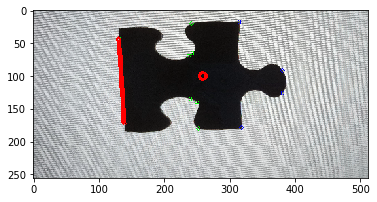

In [32]:
contour_list_left=[]
left_list =[]
img_left= img.copy()
#print(corners.ravel())
puzzle_side_shape = puzzle_shape_left(left_shape_male, left_shape_female)
print(puzzle_side_shape)
for c in contours:
    area = cv2.contourArea(c)
    if   (area  < 40000):
        for i in c:
            x,y = i.ravel()
            contour_list_left.append([x,y])
        #print(contour_list)
        for c in contour_list_left:
            puzzle_side_shape = puzzle_shape_left(left_shape_male, left_shape_female)
            print(puzzle_side_shape)
            if puzzle_side_shape == 'male':
                if (c[0] <= max(left_top_corner_point[0][0],left_bottom_corner_point[0][0])  and (left_top_corner_point[0][1] <= c[1] <= left_bottom_corner_point[0][1])):
                    cv2.circle(img_left, tuple(c), 3 , (255,0,0), 1)
                    left_list.append(c)
            if puzzle_side_shape == 'female':
                if (c[0] <= (left_top_corner_point[0][0] + 30) and (left_top_corner_point[0][1] <= c[1] <= left_bottom_corner_point[0][1])):
                    cv2.circle(img_left, tuple(c), 3 , (255,0,0), 1)
                    left_list.append(c)
#print(left_list)
plt.imshow(img_left)
cv2.imwrite("rp1.jpg" , img_left)
#print(left_list)

male
[[315, 18]]
[[318, 179]]


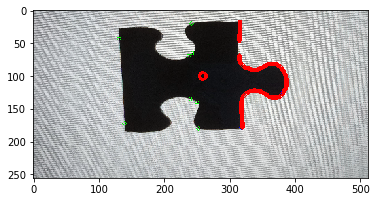

In [33]:
contour_list_right=[]
right_list =[]
img_right= img.copy()
#print(corners.ravel())
puzzle_side_shape = puzzle_shape_right(right_shape_male, right_shape_female)
print(puzzle_side_shape)
for c in contours:
    area = cv2.contourArea(c)
    
    if (area < 40000):
        for i in c:
            x,y = i.ravel()
            contour_list_right.append([x,y])
        #print(contour_list)
        for c in contour_list_right:
            puzzle_side_shape = puzzle_shape_right(right_shape_male, right_shape_female)
            if puzzle_side_shape == 'male':
                if (c[0] >= min(right_top_corner_point[0][0],right_bottom_corner_point[0][0]) and (right_top_corner_point[0][1] <= c[1] <= right_bottom_corner_point[0][1])):
                    cv2.circle(img_right, tuple(c), 3 , (255,0,0), 1)
                    right_list.append(c)
            if puzzle_side_shape == 'female':
                if (c[0] >= (max(right_top_corner_point[0][0],right_bottom_corner_point[0][0]) - 60) and (right_top_corner_point[0][1] <= c[1] <= right_bottom_corner_point[0][1])):
                    cv2.circle(img_right, tuple(c), 3 , (255,0,0), 1)
                    right_list.append(c)
#print(right_list)
plt.imshow(img_right)
print(right_top_corner_point)
print(right_bottom_corner_point)

In [41]:
print(len(contours))
#print(contours[5])
contour_5 =contours[4]
print(contour_5)

#print(contours.shape)

2


IndexError: list index out of range

In [ ]:
for contour in contours:
    contour_2 = contour.tolist()
print(contour_2)
print(contour_2[0][0])

In [ ]:
results_mod = [list(*x) for x in contour_2]
print(results_mod)

In [ ]:
b = rdp(contour_2, epsilon=0.5)
print(b)

In [ ]:
cnt = contours[4]
print(cnt)
print(cnt[0])
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
img_3 = cv2.drawContours(img,[box],0,(0,0,255),2)
print(box)
cv2.namedWindow("Frame" , cv2.WINDOW_NORMAL)
cv2.imshow("Frame", img)
cv2.imshow("Mask", mask)
key = cv2.waitKey(10000)
cv2.destroyAllWindows()
plt.imshow(img)
for i in cnt:
    img_2 = cv2.circle(img , (i[0][0],i[0][1]), 1 ,(255, 0 ,0),1)
plt.imshow(img_2)
cv2.namedWindow("Frame" , cv2.WINDOW_NORMAL)
cv2.imshow("Frame", img_2)
#cv2.imshow("Mask", mask)
#key = cv2.waitKey(10000)
cv2.destroyAllWindows()


In [ ]:
#tile_center = ndimage.center_of_mass(mask)
#tile_center = tuple(np.round(tile_center).astype(np.int))
#print(tile_center)
#for contour in contours:
    #if contour[0] < tile_center[0] and 

In [ ]:
b = rdp(cnt, epsilon=1)
print(b.tolist())
for i in b:
    img_3 = cv2.circle(img , (i[0][0],i[0][1]), 1 ,(255, 0 ,0),1)
plt.imshow(img_3)
cv2.namedWindow("Frame" , cv2.WINDOW_NORMAL)
cv2.imshow("Frame", img_3)
cv2.destroyAllWindows()

In [ ]:
contour_final =list()

for contour in contours[4]:
    area = cv2.contourArea(contour)
    #print(area)
    if   (area  > 40000 and area < 60000):
        #contour_final.append(contour)
        cv2.drawContours(img, contour, -1, (0, 255, 0), 3)

In [ ]:
cv2.namedWindow("Frame" , cv2.WINDOW_NORMAL)
cv2.imshow("Frame", img)
cv2.imshow("Mask", mask)
key = cv2.waitKey(10000)
cv2.destroyAllWindows()
plt.imshow(img)


In [ ]:
print(len(contour_final[0]))

In [ ]:
b = rdp(contour_final, epsilon=0.8)

In [ ]:
print(b)
print(len(b[0]))

In [ ]:
dst = dst * mask
data = dst.copy()
data[data < 0.1 * data.max()] = 0
datamax = filters.maximum_filter(data, 3)
maxima = (dst == datamax)
datamin = filters.minimum_filter(data, 3)
minima = (dst == datamin)
diff = ((datamax - datamin) > .01)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
# slices = ndimage.find_objects(labeled)
# yx = np.array(ndimage.center_of_mass(dst, labeled, range(1, num_objects+1)))
yx = np.array(ndimage.center_of_mass(data, labeled, range(1, num_objects + 1)))
temp = yx[:, 0].copy()
yx[:, 0] = yx[:, 1]
yx[:, 1] = temp
#print('7')
#print(np.round(yx).astype(np.int))
corners = np.round(yx).astype(np.int)
print(len(corners))
#print((corners))

for i in corners:
    img_4 = cv2.circle(img, tuple(i), 5, (0), 2)
cv2.namedWindow('corners_2', cv2.WINDOW_NORMAL)
cv2.imshow('corners_2', img_4 )
key = cv2.waitKey(10000)
cv2.destroyAllWindows()


In [ ]:
for c2 in corner_left_top_candidates:
        for c3 in corner_left_top_candidates:
            for c4 in corner_left_top_candidates:
                if not np.array_equal(c1,c2) and not np.array_equal(c1,c3) and not np.array_equal(c3,c2): 
                    if 90 - margin < get_angle(c1,c3,c2) < 90 + margin:
                        angle_candidates.append((c3,c4))
        #for j in corner_left_top_candidates_combination:
            
            #if 90 - margin < get_angle(i,j,k) < 90 + margin:
                    #angle_candidates.append([i ,j ,k])
    #print(angle_candidates)
    #
    print(angle_candidates)

In [ ]:
for i in corner_left_top_candidates_sorted:
        i = 0
        j = i+1
        k = j +1
        if 90 - margin < get_angle(corner_left_top_candidates_sorted[i], corner_left_top_candidates_sorted[j] ,corner_left_top_candidates_sorted[k]) < 90 + margin:
                        angle_candidates.append((corner_left_top_candidates_sorted[i], corner_left_top_candidates_sorted[j] ,corner_left_top_candidates_sorted[k]))
        i=i+1
    #print(angle_candidates)
    #corner_left_top_candidates_combination = list(combinations_with_replacement(corner_left_top_candidates, 2)) 
    #print(corner_left_top_candidates_combination)

In [ ]:
lower_ = np.array([30, 180, 60])
upper_ = np.array([120, 255, 255])
mask = cv2.inRange(hsv, lower_, upper_)
plt.imshow(mask)
cv2.namedWindow("Masked_Image" , cv2.WINDOW_NORMAL)
cv2.imshow("Masked_Image", mask)
key = cv2.waitKey(10000)
cv2.destroyAllWindows()
#cv2.imshow("Masked_Image", mask)

In [ ]:
rect = cv2.minAreaRect(corners)
box = cv2.boxPoints(rect)
box = np.int0(box)
img_3 = cv2.drawContours(img,[box],0,(0,0,255),2)
print(box)
cv2.namedWindow("Frame" , cv2.WINDOW_NORMAL)
cv2.imshow("Frame", img)
cv2.imshow("Mask", mask)
key = cv2.waitKey(10000)
cv2.destroyAllWindows()
plt.imshow(img)

In [ ]:
path = "."
filename= [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg')]
print(filename)

In [ ]:
lower_ = np.array([50, 180, 60])
upper_ = np.array([120, 255, 255])
mask = cv2.inRange(hsv, lower_, upper_)
plt.imshow(mask)
cv2.namedWindow("Masked_Image" , cv2.WINDOW_NORMAL)
cv2.imshow("Masked_Image", mask)
key = cv2.waitKey(10000)
cv2.destroyAllWindows()
#cv2.imshow("Masked_Image", mask)

In [ ]:
#dst = cv2.cornerHarris(mask, 2, 3, 0.04)
    # Normalizing
#dst_norm = np.empty(dst.shape, dtype=np.float32)
#cv2.normalize(dst, dst_norm, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
#dst_norm_scaled = cv2.convertScaleAbs(dst_norm)
# Drawing a circle around corners
#orner_points_j= []
#for i in range(dst_norm.shape[0]):
    #orner_points_i.append(j)
    #for j in range(dst_norm.shape[1]):
        #if int(dst_norm[i,j]) > 120:
            #corner_points_j.append(j)
            #cv2.circle(dst_norm_scaled, (j,i), 5, (0), 2)
            #rint(j)
            #rint(i)
            
            
# Showing the result
#cv2.namedWindow('corners', cv2.WINDOW_NORMAL)
#cv2.imshow('corners', dst_norm_scaled)
#plt.imshow(dst_norm_scaled)
#key = cv2.waitKey(10000)
#cv2.destroyAllWindows()

In [ ]:
tile_center1 = ndimage.center_of_mass(thresh)
print(tile_center1)
tile_center1 = tuple(np.round(tile_center1).astype(np.int))
print(tile_center1)

In [ ]:
def get_90deg_corners(pt, corners, rule1, rule2, margin = 20):
    """calculate all corners that are 90 degrees from pt, where the corners c1, c2 must comply with rule1, rule2 """
    #print(pt)
    res = []
    used = []
    #print('2')
    for c1 in corners:
        if not rule1(c1):
            continue
        #print('1')
        for c2 in corners:
            if np.array_equal(c1,c2) or np.array_equal(c2,pt) or np.array_equal(c1,pt) or \
                    not rule2(c2) or \
                    tuple(c2) in used:
                continue
            if 90 - margin < get_angle(c1,pt,c2) < 90 + margin:
                res.append((c1,c2))
                #print(res)
                used.append(tuple(c1))
    
    return res

In [ ]:
print(angle_candidates_left_top)
    left_side_height_position = []
for i in range(0, len(angle_candidates_left_top)):
    left_side_height_position.append(angle_candidates_left_top[i][0])
print(left_side_height_position)
left_shape = []
corners=corners_list
print(corners)
for c in corners:
    if c[0] < min(b):
        
        left_shape.append(c)
print(left_shape)
if len(left_shape) > 5:
    puzzle_side_shape = 'male'
    print('Left side is male shape')
    
print(angle_candidates_right_top)
    left_side_height_position = []
for i in range(0, len(angle_candidates_left_top)):
    left_side_height_position.append(angle_candidates_left_top[i][0])
print(left_side_height_position)
left_shape = []
corners=corners_list
print(corners)
for c in corners:
    if c[0] < min(b):
        left_shape.append(c)
print(left_shape)
if len(left_shape) > 5:
    puzzle_side_shape = 'male'
    print('Left side is male shape')

print(angle_candidates_right_top)
    left_side_height_position = []
for i in range(0, len(angle_candidates_left_top)):
    left_side_height_position.append(angle_candidates_left_top[i][0])
print(left_side_height_position)
left_shape = []
corners=corners_list
print(corners)
for c in corners:
    if c[0] < min(b):
        left_shape.append(c)
print(left_shape)
if len(left_shape) > 5:
    puzzle_side_shape = 'male'
    print('Left side is male shape')

In [ ]:
line1Y1 = box[0][1]
line1X1 = box[0][0]
line1Y2 = box[3][1]
line1X2 = box[3][0]

line2Y1 = 0
line2X1 = 0
line2Y2 = 0
line2X2 = 512
angle1 = math.atan2(line1Y1-line1Y2,line1X1-line1X2)
angle2 = math.atan2(line2Y1-line2Y2,line2X1-line2X2)
angleDegrees = (angle1-angle2) * 360 / (2*math.pi)
print(angleDegrees)
img=  cv2.rotate(img, angleDegrees)

In [ ]:
left_top_corner_point=[]
left_bottom_corner_point=[]
right_top_corner_point =[]
right_bottom_corner_point =[]
print(len(angle_candidates_left_top))
#rint(angle_candidates_left_top[1][0])
b = []
for i in range(0, len(angle_candidates_left_top)):
    b.append(angle_candidates_left_top[i][0])

#rint(b)

d = b.index(min(b))
#rint(d)
left_top_corner_point.append(angle_candidates_left_top[d])
print(left_top_corner_point)
b=[]
for i in range(0, len(angle_candidates_left_bottom)):
    b.append(angle_candidates_left_bottom[i][1])
#rint(b)    
d = b.index(max(b))
#rint(d)
left_bottom_corner_point.append(angle_candidates_left_bottom[d])
print(left_bottom_corner_point)

b=[]
for i in range(0, len(angle_candidates_right_top)):
    b.append(angle_candidates_right_top[i][0])
#rint(b)    
d = b.index(min(b))
#rint(d)
right_top_corner_point.append(angle_candidates_right_top[d])
print(right_top_corner_point)


b=[]
for i in range(0, len(angle_candidates_right_bottom)):
    b.append(angle_candidates_right_bottom[i][1])
#rint(b)    
d = b.index(max(b))
#rint(d)
right_bottom_corner_point.append(angle_candidates_right_bottom[d])
print(right_bottom_corner_point)

print(angle_candidates_left_top)
print(angle_candidates_left_bottom)
print(angle_candidates_right_top)
print(angle_candidates_right_bottom)

In [ ]:
def right_top_corner(angle_candidates_right_top):
    h =[]
    w=[]
    right_top_corner_point=[]
    for i in range(0, len(angle_candidates_right_top)):
        h.append(angle_candidates_right_top[i][0])
    d1 = h.index(max(h))
    for i in range(0, len(angle_candidates_right_top)):
        w.append(angle_candidates_right_top[i][1])
    d2 = w.index(min(w)) 
    right_top_corner_point.append(angle_candidates_right_top[d1])
    print(angle_candidates_right_top[d2])
    if right_top_corner_point[0][1] > angle_candidates_right_top[d2][1]:
        del angle_candidates_right_top[d1]
        right_top_corner(angle_candidates_right_top)
    #print(right_top_corner_point)
    return right_top_corner_point